In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import spotipy # install if needed
from spotipy.oauth2 import SpotifyClientCredentials
import getpass
from IPython.core.display import display
from IPython.display import IFrame
import webbrowser

# Spotify


In [3]:
client_id = str(getpass.getpass('client_id?'))
client_sectret = str(getpass.getpass('client_secret?'))

In [4]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=client_id, client_secret=client_sectret))

# Functions

In [27]:
def artists_from_playlist(playlist):
    songs = playlist['items']
    while playlist['next']:
        playlist = sp.next(playlist)
        songs.extend(playlist['items'])
    artists = []
    for item in songs:
        artists.append(item['track']['artists'][0]['name'])
    artist_id_list = []
    for artist in artists:
        artist_id = sp.search(artist)['tracks']['items'][0]['artists'][0]['id']
        artist_id_list.append(artist_id)
    return list(set(artist_id_list))

In [28]:
def all_albums_from_artists(artists_id_list):
    albums_ids = []
    for artist_id in artists_id_list:
        albums = sp.artist_albums(artist_id)
        for album in range(len(albums['items'])):
            albums_ids.append(albums['items'][album]['id'])
    return list(set(albums_ids))

def all_songs_from_albums_old(albums_id_list):
    ids = []
    titles = []
    artists = []
    artist_id_list = []
    genres = []
    audio_feat = []
    for album_id in tqdm(albums_id_list):
        songs_ids = sp.album_tracks(album_id)
        for id in range(len(songs_ids['items'])):
            ids.append(songs_ids['items'][id]['id'])
            titles.append(songs_ids['items'][id]['name'])
            artists.append(songs_ids['items'][0]['artists'][0]['name'])
            artist_id_list.append(songs_ids['items'][0]['artists'][0]['id'])
    for artist_id in tqdm(artist_id_list):
        genres.append(sp.artist(artist_id)['genres'])
    #df1 = pd.DataFrame.from_dict({'id': ids, 'title': titles, 'artist': artists, 'artist_id': artist_id_list, 'genres': genres})
    ids_chunks = []
    for i in tqdm(range(0, len(ids), 100)):
        ids_chunks.append(ids[i:i + 100])
    audio_feat = []
    for i in tqdm(ids_chunks):
        audio_feat.append(sp.audio_features(tracks=i))
    audio_feat_total = []
    for i in tqdm(range(len(audio_feat))):
        audio_feat_total += audio_feat[i]
    audio_feats_clean = [dct for dct in audio_feat_total if dct]
    df = pd.DataFrame(audio_feats_clean)
    #df = pd.concat([df1, df2.drop(['type', 'id'], axis=1)], axis=1)
    return df.drop(['type', 'track_href', 'uri', 'analysis_url'], axis=1)
    

In [29]:
def all_songs_from_albums(albums_id_list):
    ids = []
    for album_id in tqdm(albums_id_list):
        songs_ids = sp.album_tracks(album_id)
        for id in range(len(songs_ids['items'])):
            ids.append(songs_ids['items'][id]['id'])         
    ids_chunks = []
    for i in tqdm(range(0, len(ids), 100)):
        ids_chunks.append(ids[i:i + 100])
    audio_feat = []
    for i in tqdm(ids_chunks):
        audio_feat.append(sp.audio_features(tracks=i))
    audio_feat_total = []
    for i in tqdm(range(len(audio_feat))):
        audio_feat_total += audio_feat[i]
    audio_feats_clean = [dct for dct in audio_feat_total if dct]
    df = pd.DataFrame(audio_feats_clean)
    return df.drop(['type', 'track_href', 'uri', 'analysis_url'], axis=1)
    

In [31]:
def get_track_id(song):
    id_search = sp.search(song)
    if len(id_search['tracks']['items']) > 0:
        print()
        return id_search['tracks']['items'][0]['id']
    else:
        print('Typo? Try again')

In [32]:
def get_audio_features(song_id):
    a_f = sp.audio_features(tracks=song_id)
    if a_f:
        df = pd.DataFrame(a_f)
        return df.drop(['type', 'track_href', 'uri', 'analysis_url', 'id'], axis=1)
    else:
        return print('no features :(..')

In [77]:
def GNOD():
    song = input('Enter a name of the song:')
    song_id = get_track_id(song)
    artist_name = sp.track(song_id)
    print(artist_name.keys())
    target_cluster = df_cluster[df_cluster['id'] == song_id]['cluster']
    # if the song is in the df
    if len(target_cluster) > 0:
        target_cluster = int(target_cluster)
    # if not in df, get the features, predict the cluster
    else:
        a_f = get_audio_features(song_id)
        scaled = scaler.transform(a_f)
        a_f_scaled = pd.DataFrame(scaled)
        a_f_norm = pd.DataFrame(transformer.transform(a_f_scaled))
        target_cluster = kmeans.predict(a_f_norm)[0]
    cluster_group = df_cluster[df_cluster['cluster'] == target_cluster]
    next_song = cluster_group.sample()
    next_id = next_song['id'].values[0]
    display(IFrame(src=f"https://open.spotify.com/embed/track/{next_id}", width="320", height="80",
                    frameborder="0", allowtransparency="true", allow="encrypted-media"))
    webbrowser.open(url=f'https://open.spotify.com/embed/track/{next_id}')

In [78]:
GNOD()


dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])


# Playlists

In [26]:
rock_playlist = sp.user_playlist_tracks('spotify', '37i9dQZF1DWXRqgorJj26U')

In [11]:
jazz_playlist = sp.user_playlist_tracks('spotify', '37i9dQZF1DXbITWG1ZJKYt')

In [ ]:
metal_playlist = sp.user_playlist_tracks('spotify', '37i9dQZF1DWWOaP4H0w5b0')

In [115]:
punk_playlist = sp.user_playlist_tracks('spotify', '37i9dQZF1DXd6tJtr4qeot')

In [116]:
classical_playlist = sp.user_playlist_tracks('spotify', '37i9dQZF1DXd6tJtr4qeot')

In [117]:
pop_playlist = sp.user_playlist_tracks('spotify', '3ZgmfR6lsnCwdffZUan8EA')

In [118]:
hiphop_playlist = sp.user_playlist_tracks('spotify', '37i9dQZF1DX30w0JtSIv4j')

In [119]:
deephouse_playlist = sp.user_playlist_tracks('spotify', '37i9dQZF1DWWEJlAGA9gs0')

# Collecting

In [21]:
rock_artists = artists_from_playlist(rock_playlist)
rock_albums = all_albums_from_artists(rock_artists)
rock_songs = all_songs_from_albums(rock_albums)
rock_songs.to_csv('rock_songs.csv')

In [31]:
jazz_artists = artists_from_playlist(jazz_playlist)
jazz_albums = all_albums_from_artists(jazz_artists)
jazz_songs = all_songs_from_albums(jazz_albums)
jazz_songs.to_csv('jazz_songs.csv')

In [ ]:
metal_artists = artists_from_playlist(metal_playlist)
metal_albums = all_albums_from_artists(metal_artists)
metal_songs = all_songs_from_albums(metal_albums)
metal_songs.to_csv('metal_songs.csv')

In [ ]:
punk_artists = artists_from_playlist(punk_playlist)
punk_albums = all_albums_from_artists(punk_artists)
punk_songs = all_songs_from_albums(punk_albums)
punk_songs.to_csv('punk_songs.csv')

In [ ]:
classical_artists = artists_from_playlist(classical_playlist)
classical_albums = all_albums_from_artists(classical_artists)
classical_songs = all_songs_from_albums(classical_albums)
classical_songs.to_csv('classical_songs.csv')

In [ ]:
pop_artists = artists_from_playlist(pop_playlist)
pop_albums = all_albums_from_artists(pop_artists)
pop_songs = all_songs_from_albums(pop_albums)
pop_songs.to_csv('pop_songs.csv')

In [ ]:
hiphop_artists = artists_from_playlist(hiphop_playlist)
hiphop_albums = all_albums_from_artists(hiphop_artists)
hiphop_songs = all_songs_from_albums(hiphop_albums)
hiphop_songs.to_csv('hiphop_songs.csv')

# Wrangling & Cleaning

In [3]:
rock = pd.read_csv('rock_songs.csv')

In [4]:
rock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23930 entries, 0 to 23929
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        23930 non-null  int64  
 1   id                23930 non-null  object 
 2   title             23930 non-null  object 
 3   artist            23930 non-null  object 
 4   artist_id         23930 non-null  object 
 5   genres            23930 non-null  object 
 6   danceability      23930 non-null  float64
 7   energy            23930 non-null  float64
 8   key               23930 non-null  int64  
 9   loudness          23930 non-null  float64
 10  mode              23930 non-null  int64  
 11  speechiness       23930 non-null  float64
 12  acousticness      23930 non-null  float64
 13  instrumentalness  23930 non-null  float64
 14  liveness          23930 non-null  float64
 15  valence           23930 non-null  float64
 16  tempo             23930 non-null  float6

In [5]:
rock.drop(['title', 'artist', 'artist_id', 'genres', 'uri', 'track_href', 'analysis_url'], axis=1, inplace=True)

In [6]:
rock.head()

,Unnamed: 0,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,1uW2vabvdnFLqCdcqE6KlO,0.533,0.998,4,-3.972,1,0.0926,0.000932,0.000001,0.2290,0.501,150.036,210900,4
1,1,2Bc99Am3PqcUNOqYLpCRsQ,0.480,0.980,4,-4.436,1,0.0854,0.001150,0.000000,0.2210,0.719,73.977,162052,4
2,2,1L9Pz5YARvakZNBElvkZjR,0.554,0.938,11,-4.901,0,0.0532,0.000176,0.000003,0.1470,0.400,96.500,209703,4
3,3,0lXuYThT8kQag9Xsc80T41,0.509,0.843,7,-5.628,1,0.0275,0.001040,0.000012,0.0882,0.479,156.073,274615,4
4,4,0wALhdvIu3D3h1qnSo214u,0.540,0.993,11,-4.136,1,0.0958,0.000036,0.001530,0.3330,0.273,107.996,176544,3


In [7]:
rock_id = rock['id']

In [8]:
rock.drop(['id'], axis=1, inplace=True)

In [9]:
rock.insert(12, 'id', rock_id)

In [10]:
rock.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0,0.533,0.998,4,-3.972,1,0.0926,0.000932,0.000001,0.2290,0.501,150.036,1uW2vabvdnFLqCdcqE6KlO,210900,4
1,1,0.480,0.980,4,-4.436,1,0.0854,0.001150,0.000000,0.2210,0.719,73.977,2Bc99Am3PqcUNOqYLpCRsQ,162052,4
2,2,0.554,0.938,11,-4.901,0,0.0532,0.000176,0.000003,0.1470,0.400,96.500,1L9Pz5YARvakZNBElvkZjR,209703,4
3,3,0.509,0.843,7,-5.628,1,0.0275,0.001040,0.000012,0.0882,0.479,156.073,0lXuYThT8kQag9Xsc80T41,274615,4
4,4,0.540,0.993,11,-4.136,1,0.0958,0.000036,0.001530,0.3330,0.273,107.996,0wALhdvIu3D3h1qnSo214u,176544,3


In [11]:
rock.to_csv('rock_clean.csv')

In [42]:
jazz = pd.read_csv('jazz_songs.csv')
metal = pd.read_csv('metal_songs.csv')
punk = pd.read_csv('punk_songs.csv')
classical = pd.read_csv('classical_songs.csv')
pop = pd.read_csv('pop_songs.csv')
hiphop = pd.read_csv('hiphop_songs.csv')

In [43]:
rock.shape

(23930, 15)

In [44]:
df_songs = pd.concat([rock, jazz, metal, punk, classical, pop, hiphop], ignore_index=True, axis=0)

In [45]:
df_songs.shape

(113279, 15)

In [46]:
df_songs.duplicated(subset=['id']).value_counts()

False    103017
True      10262
dtype: int64

In [47]:
df_songs.drop_duplicates(subset=['id'], inplace=True, ignore_index=True)

In [48]:
df_songs.shape

(103017, 15)

In [49]:
df_songs.tail()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
103012,8968,0.654,0.300,7,-6.800,1,0.0646,0.7860,0.971,0.1070,0.311,175.956,0QkkafZWUaNecgzlD9bMoY,148125,4
103013,8969,0.863,0.313,7,-10.359,1,0.1080,0.6300,0.891,0.1000,0.777,88.021,3IksdiASh2b06yxTwxj5bi,70300,4
103014,8970,0.591,0.275,1,-8.007,0,0.1140,0.2550,0.964,0.0626,0.852,187.063,29Q8SKVRDyQvPO0CqMazj8,148944,4
103015,8971,0.632,0.269,11,-9.024,1,0.0878,0.0660,0.894,0.1070,0.565,182.144,5wnRs4fnmiqNQcwwl7AL4Y,122382,4
103016,8972,0.655,0.500,3,-5.622,0,0.1300,0.0718,0.415,0.2000,0.621,162.370,3OM7NZafi50mlHVhsAYYBu,184254,4


In [50]:
df_songs.shape

(103017, 15)

In [51]:
df_songs.reset_index(drop=True, inplace=True)

In [52]:
df_ids = pd.DataFrame(df_songs['id'])

In [53]:
df_ids.tail()

,id
103012,0QkkafZWUaNecgzlD9bMoY
103013,3IksdiASh2b06yxTwxj5bi
103014,29Q8SKVRDyQvPO0CqMazj8
103015,5wnRs4fnmiqNQcwwl7AL4Y
103016,3OM7NZafi50mlHVhsAYYBu


In [54]:
df_songs.drop(['Unnamed: 0', 'id'], inplace=True, axis=1)

In [55]:
df_songs.tail()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
103012,0.654,0.300,7,-6.800,1,0.0646,0.7860,0.971,0.1070,0.311,175.956,148125,4
103013,0.863,0.313,7,-10.359,1,0.1080,0.6300,0.891,0.1000,0.777,88.021,70300,4
103014,0.591,0.275,1,-8.007,0,0.1140,0.2550,0.964,0.0626,0.852,187.063,148944,4
103015,0.632,0.269,11,-9.024,1,0.0878,0.0660,0.894,0.1070,0.565,182.144,122382,4
103016,0.655,0.500,3,-5.622,0,0.1300,0.0718,0.415,0.2000,0.621,162.370,184254,4


In [56]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103017 entries, 0 to 103016
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      103017 non-null  float64
 1   energy            103017 non-null  float64
 2   key               103017 non-null  int64  
 3   loudness          103017 non-null  float64
 4   mode              103017 non-null  int64  
 5   speechiness       103017 non-null  float64
 6   acousticness      103017 non-null  float64
 7   instrumentalness  103017 non-null  float64
 8   liveness          103017 non-null  float64
 9   valence           103017 non-null  float64
 10  tempo             103017 non-null  float64
 11  duration_ms       103017 non-null  int64  
 12  time_signature    103017 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 10.2 MB


# Scaling & Normalizing

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
%matplotlib inline

In [58]:
scaler = StandardScaler().fit(df_songs)
scaled = scaler.transform(df_songs)
df_scaled = pd.DataFrame(scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.048460,1.385044,-0.333833,0.968806,0.742510,-0.040903,-0.890128,-0.485872,-0.167706,0.142417,1.001850,-0.318407,0.219814
1,-0.265791,1.317343,-0.333833,0.875336,0.742510,-0.098274,-0.889507,-0.485877,-0.199396,1.059687,-1.521630,-0.698206,0.219814
2,0.172975,1.159373,1.657329,0.781664,-1.346784,-0.354853,-0.892280,-0.485867,-0.492523,-0.282556,-0.774364,-0.327714,0.219814
3,-0.093842,0.802062,0.519522,0.635213,0.742510,-0.559638,-0.889820,-0.485834,-0.725441,0.049849,1.202145,0.176984,0.219814
4,0.089965,1.366238,1.657329,0.935769,0.742510,-0.015404,-0.892678,-0.480393,0.244256,-0.816929,-0.392950,-0.585529,-2.032260


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>],
       [<AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>],
       [<AxesSubplot:title={'center':'12'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

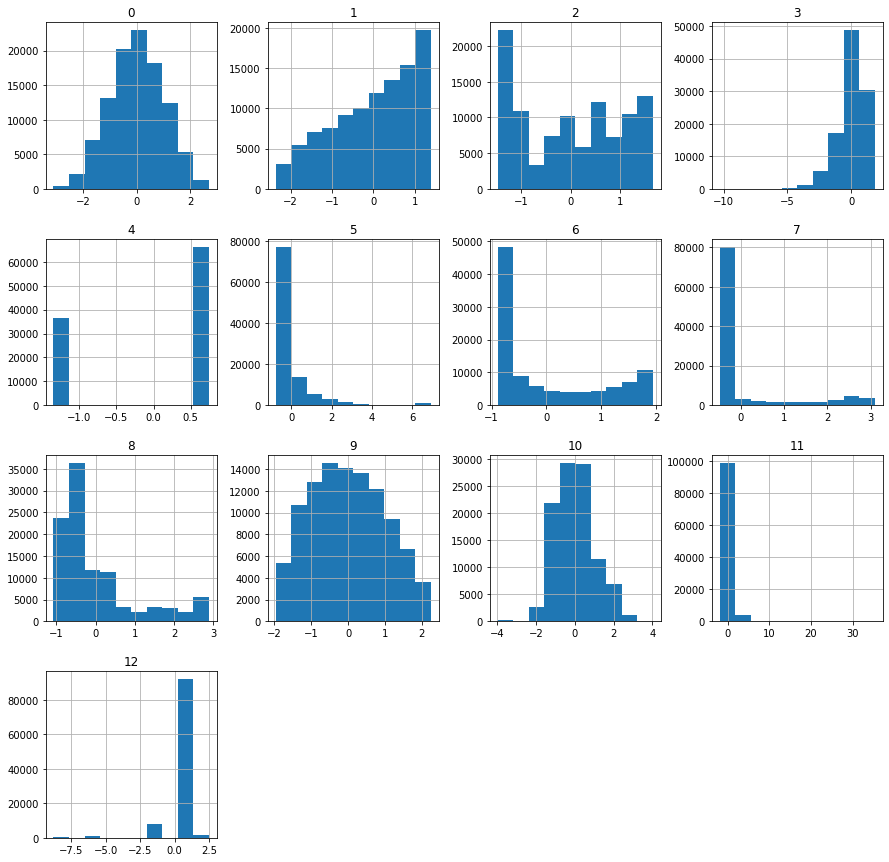

In [59]:
df_scaled.hist(figsize=(15, 15))

In [60]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(df_scaled)
df_norm = pd.DataFrame(transformer.transform(df_scaled))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>],
       [<AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>],
       [<AxesSubplot:title={'center':'12'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

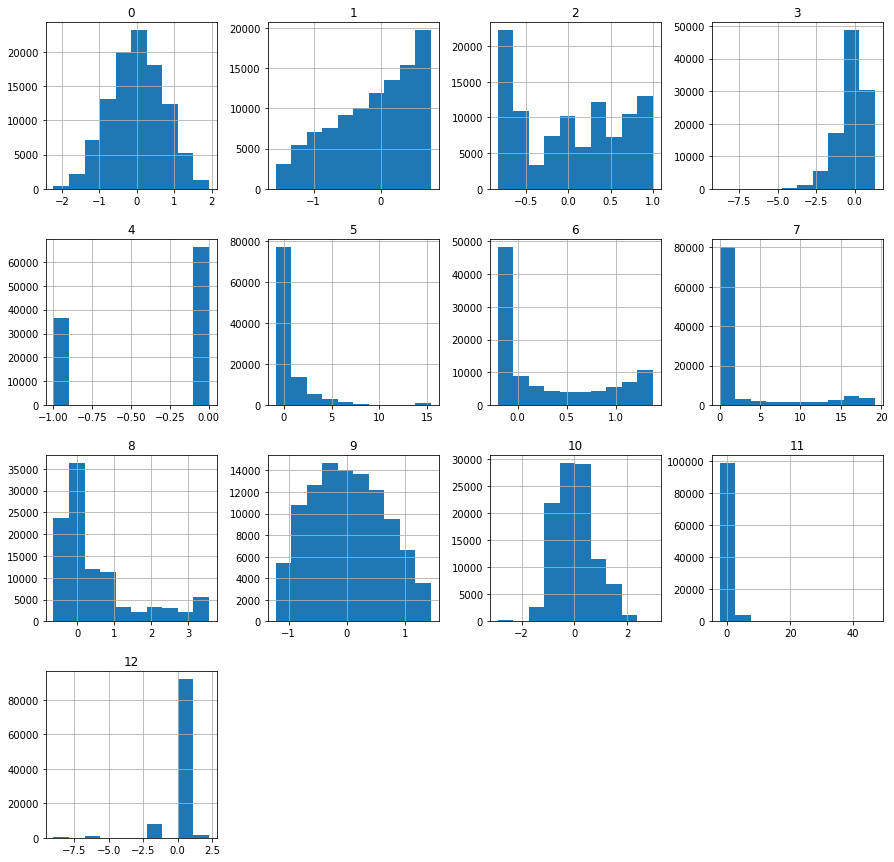

In [61]:
df_norm.hist(figsize=(15, 15))

# KMeans

In [62]:
inertia = []
K = range(5, 15)
for x in K:
    kmeans = KMeans(n_clusters=x,
                    init="random",
                    n_init=6,  # try with 1, 4, 8, 20, 30, 100...
                    max_iter=100,
                    tol=0,
                    algorithm="full",
                    random_state=88)
    kmeans.fit(df_norm)
    inertia.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

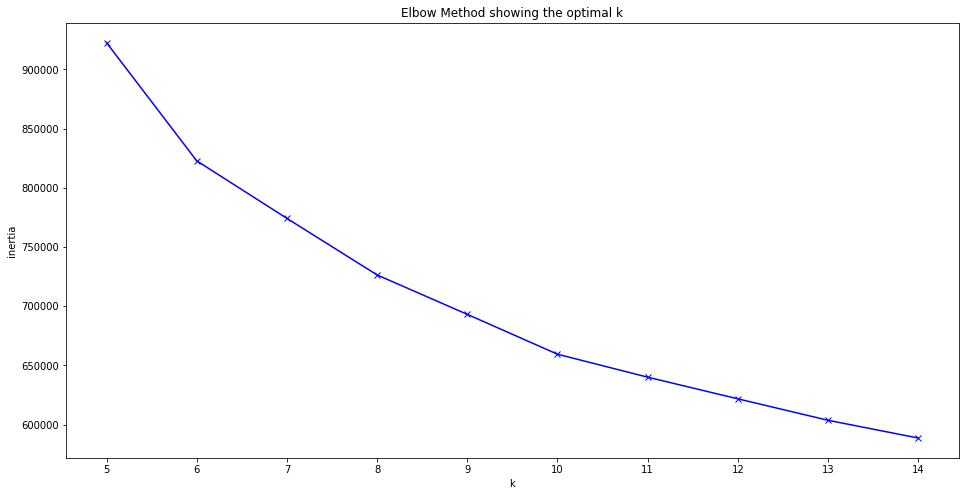

In [63]:
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [64]:
K = range(7, 13)

silhouettes = []
df_sample = df_norm.sample(frac=0.5)
for x in tqdm(K):
    kmeans = KMeans(n_clusters=x,
                    init="random",
                    n_init=6,  # try with 1, 4, 8, 20, 30, 100...
                    max_iter=100,
                    #tol=0,
                    algorithm="full",
                    random_state=88)
    kmeans.fit(df_sample)
    silhouettes.append(silhouette_score(df_sample, kmeans.predict(df_sample)))

  0%|          | 0/6 [00:00<?, ?it/s]

Text(0, 0.5, 'silhouette score')

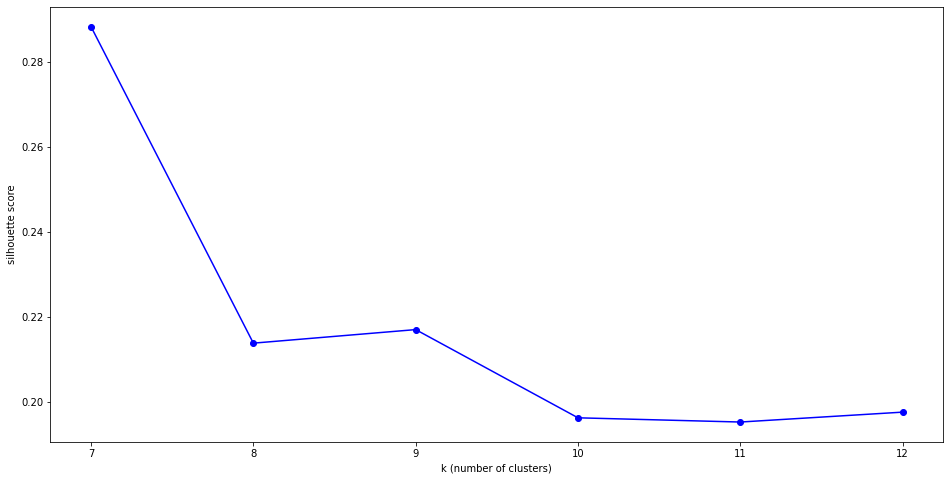

In [65]:
plt.figure(figsize=(16,8))
plt.plot(K, silhouettes, 'bo-')
plt.xlabel('k (number of clusters)')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.ylabel('silhouette score')

In [66]:
kmeans = KMeans(n_clusters=9, random_state=88, max_iter=500).fit(df_norm)
clusters = kmeans.predict(df_norm)

In [67]:
pd.Series(clusters).value_counts().sort_index()

0    42697
1     9667
2     5456
3     4981
4     9483
5     1464
6     3224
7    16590
8     9455
dtype: int64

In [68]:
df_cluster = pd.DataFrame(df_ids)
df_cluster['cluster'] = clusters
df_cluster.tail()

,id,cluster
103012,0QkkafZWUaNecgzlD9bMoY,1
103013,3IksdiASh2b06yxTwxj5bi,1
103014,29Q8SKVRDyQvPO0CqMazj8,1
103015,5wnRs4fnmiqNQcwwl7AL4Y,1
103016,3OM7NZafi50mlHVhsAYYBu,2


In [69]:
GNOD()


{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/07QEuhtrNmmZ0zEcqE9SF6'}, 'href': 'https://api.spotify.com/v1/artists/07QEuhtrNmmZ0zEcqE9SF6', 'id': '07QEuhtrNmmZ0zEcqE9SF6', 'name': 'Owl City', 'type': 'artist', 'uri': 'spotify:artist:07QEuhtrNmmZ0zEcqE9SF6'}], 'available_markets': ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT', 'AU', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BN', 'BO', 'BR', 'BS', 'BT', 'BW', 'BY', 'BZ', 'CA', 'CH', 'CI', 'CL', 'CM', 'CO', 'CR', 'CV', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DM', 'DO', 'EC', 'EE', 'EG', 'ES', 'FI', 'FJ', 'FM', 'FR', 'GA', 'GB', 'GD', 'GH', 'GM', 'GN', 'GQ', 'GR', 'GT', 'GW', 'GY', 'HK', 'HN', 'HR', 'HT', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JM', 'JO', 'JP', 'KE', 'KG', 'KH', 'KI', 'KM', 'KN', 'KR', 'KW', 'KZ', 'LA', 'LB', 'LC', 'LI', 'LK', 'LR', 'LS', 'LT', 'LU', 'LV', 'MC', 'MD', 'ME', 'MG', 'MH', 'MK', 'ML', 'MN', 'MO', 'MR', 'MT', 'MU', 'MV', 'MW', 'MX',

NameError: name 'webbrowser' is not defined

In [ ]:
import webbrowser

In [ ]:
webbrowser.open(url='https://open.spotify.com/track/5l5IjBzuVWog64CYMmGqzu')

True

In [ ]:
GNOD()